In [1]:
from pathlib import Path
import numpy as np 
import xml.etree.ElementTree as ET
from sklearn.svm import SVC, LinearSVC
from skimage.io import imread
from skimage import img_as_float
from skimage.transform import resize
# from concurrent.futures import ThreadPoolExecutor as PoolExecutor
# from concurrent.futures import as_completed
from joblib import Parallel, delayed
from time import time
from tqdm import tqdm

from pillclassification.feature_extraction import feature_extraction
from pillclassification.functions import crop_center, generate_image
from utils.utils import tqdm_joblib
import warnings
warnings.filterwarnings('ignore')

images_dir = Path('utils/Dataset/merge')
filenames = [x for x in images_dir.iterdir() if x.suffix != '.xml']
bg_dir = Path('utils/backgrounds')
bgs = [x for x in bg_dir.iterdir()]

samples_num = len(filenames)
feature_number = 10
generate_n = 10

In [3]:
# calculating labels 
try:
    tree = ET.parse(images_dir / 'images.xml')
except ET.ParseError:
    print('Parse error on {}'.format(images_dir / 'images.xml'))
    exit(-1)

se = list(tree.getroot())[0]

labels_set = set()
segmented = 0

for e in list(se):
    labels_set.add(e.find('NDC9').text)
    layout = e.find('Layout')
    if layout is not None and layout.text == "MC_C3PI_REFERENCE_SEG_V1.6":
        segmented += 1

labels = sorted(list(labels_set))
class_num = len(labels)

final_samples = segmented * generate_n + len(filenames) - segmented
print(final_samples)

3406


In [153]:
def extract_features(f):
    # loading the image 
    try:
        img = imread(f)
    except ValueError as e:
        return None
    
    
    features = np.ndarray((0,10))
    labels_ = []
    
    # img is rgba
    if img.shape[-1] == 4:
        for _ in range(generate_n):
            generated = generate_image(img, bgs[np.random.randint(0, len(bgs))])
            try:
                hu, rgb_val = feature_extraction(generated)
            except ValueError:
                continue
                
            label = -1
            for e in list(se):
                if e.find('File').find('Name').text == f.name:
                    label = labels.index(e.find('NDC9').text)
                    break
            features = np.append(features, [np.append(hu, rgb_val)], axis=0)
            labels_ = np.append(labels_, label)
        return features, labels_
    
    # cropping in the center
    img = crop_center(img, crop_scale=0.6)

    # rescaling with fixed width
    width = 600
    img = resize(img, (int(img.shape[0] * (width / img.shape[1])), width), anti_aliasing=True)

    # the img must be in float format 
    img = img_as_float(img)
    
    # feature extraction
    try:
        hu, rgb_val = feature_extraction(img)
    except ValueError:
        return None

    label = -1
    for e in list(se):
        if e.find('File').find('Name').text == f.name:
            label = labels.index(e.find('NDC9').text)
            break
    
    features = np.append(features, [np.append(hu, rgb_val)], axis=0)
    labels_ = np.append(labels_, label)
    return features, labels_

In [6]:
# extracting features

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

per_batch = 500
batches = list(chunks(filenames, per_batch))

with tqdm_joblib(tqdm(desc="Feature extraction", total=len(filenames))) as progress_bar:
    with Parallel(n_jobs=12) as parallel:
        for idx, batch in enumerate(batches):
            x_data = np.ndarray((0, feature_number))
            y_data = np.array([], dtype=np.int32)
            for _, r in enumerate(parallel(delayed(extract_features)(f) for f in batch)):
                if r is not None:
                    x_data = np.concatenate((x_data, r[0]))
                    y_data = np.concatenate((y_data, r[1]))

            # printing and saving the features as npy file
            # print(x_data)
            # print(y_data)
            np.save('x{}_data_saved'.format(idx), x_data)
            np.save('y{}_data_saved'.format(idx), y_data)

Feature extraction:   0%|          | 0/742 [00:00<?, ?it/s]


NameError: name 'extract_features' is not defined

In [145]:
# loading features if already extracted
x_data = np.load('x_data_saved.npy')
y_data = np.load('y_data_saved.npy')

# print(x_data.shape)
# print(y_data.shape)

# print(y_data)

In [157]:
n_train = len(x_data) * 90 // 100
print(n_train)
print(len(x_data) - n_train)

2897
322


In [8]:
from collections import Counter

# Load all features

x_data = np.ndarray((0, feature_number))
y_data = np.array([], dtype=np.int32)

for i in range(len(batches)):
    x_data = np.concatenate((x_data, np.load('x{}_data_saved.npy'.format(i))))
    y_data = np.concatenate((y_data, np.load('y{}_data_saved.npy'.format(i))))
    
# Clear data from nan
idx = np.isnan(x_data[:])
idx = np.where(np.any(idx == True, axis=1))

for i in idx:
    x_data = np.delete(x_data, i, 0)
    y_data = np.delete(y_data, i, 0)
    
# Divide dataset in train + test

idx_sort = np.argsort(y_data)

y_sorted = y_data.take(idx_sort, 0)
x_sorted = x_data.take(idx_sort, 0)

j = 0

idx_train = []

cnt = Counter() 

for y in y_sorted:
    cnt[int(y)] += 1

for i in range(class_num):
    train_n = int(cnt[i] * 0.9)
    for e in y_sorted[j:]:
        if e == i:
            break
        j += 1
    idx_train.extend(range(j, train_n + j))

idx_test = np.delete(list(range(len(y_data))), idx_train, 0)
X = x_sorted
Y = y_sorted

In [9]:
# Outlier detection

from sklearn.ensemble import IsolationForest

iso = IsolationForest(warm_start=True)
yhat = iso.fit_predict(X[idx_train])

# select all rows that are not outliers
mask = yhat != -1
X_train = X[idx_train]
y_train = Y[idx_train]
X_train, y_train = X_train[mask, :], y_train[mask]


yhat = iso.fit_predict(X[idx_test])

mask = yhat != -1
X_test = X[idx_test]
y_test = Y[idx_test]
X_test, y_test = X_test[mask, :], y_test[mask]

# summarize the shape of the updated training dataset
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3218, 10) (3218,)
(2170, 10) (2170,)
(238, 10) (238,)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def get_name(estimator):
    name = estimator.__class__.__name__
    if name == 'Pipeline':
        name = [get_name(est[1]) for est in estimator.steps]
        name = ' + '.join(name)
    return name


# list of (estimator, param_grid), where param_grid is used in GridSearchCV
classifiers = [
    (make_pipeline(
        KBinsDiscretizer(encode='onehot'),
        LogisticRegression(random_state=0)), {
            'kbinsdiscretizer__n_bins': np.arange(2, 10),
            'logisticregression__C': np.logspace(-2, 7, 10),
        }),
    (make_pipeline(
        KBinsDiscretizer(encode='onehot'),
        LinearSVC(random_state=0, tol=1e-6, max_iter=10000)), {
            'kbinsdiscretizer__n_bins': np.arange(2, 10),
            'linearsvc__C': np.logspace(-2, 7, 10),
        }),
    (GradientBoostingClassifier(n_estimators=100, random_state=0), {
        'learning_rate': np.logspace(-4, 0, 10)
    }),
    (SVC(random_state=0, tol=1e-6, max_iter=10000), {
        'C': np.logspace(-2, 7, 10)
    }),
]

names = [get_name(e) for e, g in classifiers]

clfs = []

from sklearn.metrics import mean_absolute_error

for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
    clf = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs = -1)
    clfs.append(clf)
    with ignore_warnings(category=ConvergenceWarning):
        clf.fit(X_train, y_train)
    
    # evaluate the model
    yhat = clf.predict(X_test)
    # evaluate predictions
    mae = mean_absolute_error(y_test, yhat)
    
    score = clf.score(X_test, y_test)
    print('{} MAE: {:.3f} Score: {:.3f}'.format(name, mae, score))

KBinsDiscretizer + LogisticRegression MAE: 3.353 Score: 0.630


KeyboardInterrupt: 

In [273]:
i = 0
print('Predicted: {}, Truth: {}'.format(clfs[4].predict([X[idx_test][i]])[0], Y[idx_test][i]))

Predicted: 0.0, Truth: 0.0


In [246]:
# print(x[0])
# print(y_data)

import matplotlib.pyplot as plt
# r = lin_clf.predict([x[0]])
# print(lin_clf.decision_function([x[0]]))

print(lin_clf.score(X[idx_test], Y[idx_test]))

0.5226586102719033


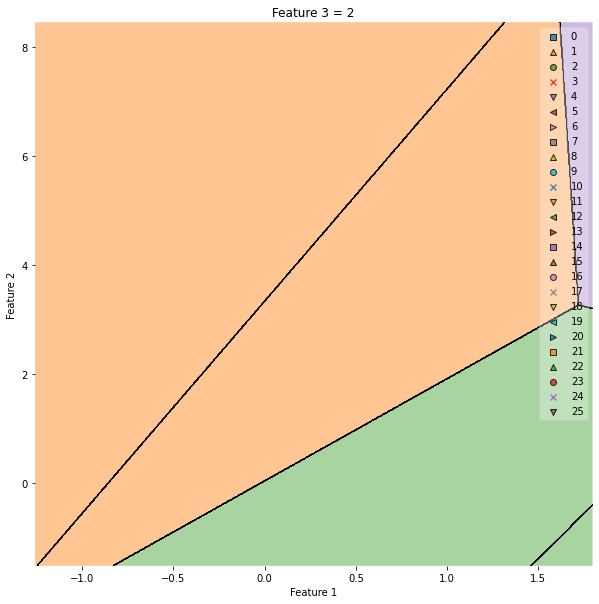

In [194]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Plotting decision regions
fig, ax = plt.subplots(figsize=(10,10))
# Decision region for feature 3 = 1.5
value = 2
# Plot training sample with feature 3 = 1.5 +/- 0.75
width = 0.75

feature_values = {i:value for i in range(2, 10)}  
feature_width = {i:value for i in range(2, 10)}  

plot_decision_regions(X, Y.astype(np.integer), clf=lin_clf,
                      filler_feature_values=feature_values,
                      filler_feature_ranges=feature_width,
                      res=0.02, ax=ax)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Feature 3 = {}'.format(value))

plt.show()